# Optimization and Initialization 

In [1]:
!conda info 



     active environment : DL-torch-arm64
    active env location : /Applications/anaconda3/envs/DL-torch-arm64
            shell level : 1
       user config file : /Users/antoineherbet/.condarc
 populated config files : /Users/antoineherbet/.condarc
          conda version : 24.7.1
    conda-build version : 24.5.1
         python version : 3.12.2.final.0
                 solver : libmamba (default)
       virtual packages : __archspec=1=m1
                          __conda=24.7.1=0
                          __osx=14.5=0
                          __unix=0=0
       base environment : /Applications/anaconda3  (writable)
      conda av data dir : /Applications/anaconda3/etc/conda
  conda av metadata url : None
           channel URLs : https://conda.anaconda.org/conda-forge/osx-arm64
                          https://conda.anaconda.org/conda-forge/noarch
                          https://repo.anaconda.com/pkgs/main/osx-arm64
                          https://repo.anaconda.com/pkgs/main/n

In [2]:
import torch
from torch import mps

# If Metal Performance Shader (mps) is not available tell me:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

# If mps is available directly put it on the device.
else:
    device = torch.device("mps")
,
# If cuda (nvidia gpu) is not available tell me:
if not torch.cuda.is_available():
    print("Cuda not available because the current PyTorch install was not "
              "built with Cuda enabled.")
   

# If cuda is available directly put it on the device.
else:
    device = torch.device("cuda")
,

# Is mps available?

mps_avail = torch.backends.mps.is_available() 
print(f"Is Metal Performance Shader (mps) available? {mps_avail}")

,

# Is mps available?

cuda_avail = torch.cuda.is_available() 
print(f"Is Cuda available? {cuda_avail}")

Cuda not available because the current PyTorch install was not built with Cuda enabled.
Is Metal Performance Shader (mps) available? True
Is Cuda available? False


In this tutorial, we will review techniques for optimization and initialization of neural networks. When increasing the depth of neural networks, there are various challenges we face. Most importantly, we need to have a stable gradient flow through the network, as otherwise, we might encounter vanishing or exploding gradients. This is why we will take a closer look at the following concepts: initialization and optimization.

In the first half of the notebook, we will review different initialization techniques, and go step by step from the simplest initialization to methods that are nowadays used in very deep networks. In the second half, we focus on optimization comparing the optimizers SGD, SGD with Momentum, and Adam.

Let's start with importing our standard libraries:

In [3]:
## Standard libraries
import os
import json
import math
import numpy as np
import copy

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib_inline
%matplotlib inline
from IPython.display import set_matplotlib_formats
matplotlib_inline.backend_inline.set_matplotlib_formats('svg','pdf')
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

We will use the same set_seed function as in Notebook 2, as weel as the path variables DATASET_PATH and CHECKPOINT_PATH.
Adjust the paths if necessary.

In [4]:
#  path to the folder where the datasets are/ should be downloaded (eg MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial4"

# function for setting the seed 
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.backends.mps.is_available(): # GPU operation have separate seeds
        torch.mps.manual_seed(seed)
 #       torch.mps.manual_seed_all(seed)
set_seed(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproductibility
torch.backends.mps.deterministic=True
torch.backends.mps.benchmark=False

# Fetching the device that will be used throughout this notebook
# We already define a GPU device with mps before but if this notebook is launched on a Nvidia GPU:
#device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print(f"Using device : {device}")

Using device : mps


in the last part of the notebook, we will train models using different optimizers. The pretrained models for those are downloaded below:


In [5]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial4/"
# Files to download
pretrained_files = ["FashionMNIST_SGD.config",    "FashionMNIST_SGD_results.json",    "FashionMNIST_SGD.tar",
                    "FashionMNIST_SGDMom.config", "FashionMNIST_SGDMom_results.json", "FashionMNIST_SGDMom.tar",
                    "FashionMNIST_Adam.config",   "FashionMNIST_Adam_results.json",   "FashionMNIST_Adam.tar"   ]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

## Préparation

Throughout this notebook, we will use a deep fully connected netword, similar to our previous notebook. We will also gain apply the network to FashionMNIST, so you can relate to the resultsts of Notebook 2. We start by loading the FashionMNIST dataset:

In [6]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# transformations applied on each image => first make them a tensor, then normalize them with mean 0 and std 1 
transform = transforms.Compose([ transforms.ToTensor(),
                               transforms.Normalize((0.2861,), (0.3530,)) # here is 2 paramaters for black and white)
                               ])                                         # we will calculate them just after

# loading the training dataset. We need to split into a training and validation part 
train_dataset = FashionMNIST(root=DATASET_PATH, train = True, transform=transform, download=True)
train_set , val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# load the test set:
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# we define a set of data loaders that we can use for various purposes later.
# note that for actually training a model, we will use different data loaders
# with a lower batch size.

train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)


                               

In comparison to the previous notebook, we have changed the parameters of the normalization transformation transforms.Normalize. The normalization is now designed to give us an expected mean of 0 and a standard deviation of 1 across pixels. This will be particularly relevant for the discussion about initialization we will look at below, and hence we change it here. It should be noted that in most classification tasks, both normalization techniques (between -1 and 1 or mean 0 and stddev 1) have shown to work well. We can calculate the normalization parameters by determining the mean and standard deviation on the original images:

In [7]:
print("Mean", (train_dataset.data.float() / 255.0).mean().item())
print("Std", (train_dataset.data.float() / 255.0).std().item())

Mean 0.28604063391685486
Std 0.3530242443084717


We can verify the transformation by looking at the statistics of a single batch:

In [8]:
imgs, _ = next(iter(train_loader))
print(f"Mean: {imgs.mean().item():5.3f}")
print(f"Standard Deviation: {imgs.std().item():5.3f}")
print(f"Maximum: {imgs.max().item():5.3f}")
print(f"Mimimum: {imgs.min().item():5.3f}")

Mean: 0.020
Standard Deviation: 1.011
Maximum: 2.022
Mimimum: -0.810


Note that the maximum and minimum are not 1 and -1 anymore, but shifted towards the positive values. This is because FashionMNIST contains a lot of black pixels, similar to MNIST.
Next, we create a linear neural network. We use the same setup as in the previous tutorial.

In [9]:
class BaseNetwork(nn.Module):

    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Inputs:
            act_fn - Object of the activation function that should be used as non-linearity in the network.
            input_size - Size of the input images in pixels
            num_classes - Number of classes we want to predict
            hidden_sizes - A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.ModuleList(layers) # A module list registers a list of modules as submodules (e.g. for parameters)

        self.config = {"act_fn": act_fn.__class__.__name__, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes}

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            x = l(x)
        return x

For the activation functions, we make use of PyTorch's __torch.nn__ library instead of implementing ourselves. However, we also define an __Identity__ activation function. Although this activation function would significantly limit the network's modeling capabilities, we will use it in the first steps of our discussion about initialization (for simplicity). 

In [10]:
class Identity(nn.Module):
    def forward(self,x):
        return x 

act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "identity": Identity
}

Finally, we define a few plotting functions that we will use for our discussions. These functions help us to (1) visualize the weight/parameter distribution inside a network, (2) visualize the gradients that the parameters at different layers receive, and (3) the activations, i.e. the output of the linear layers. The detailed code is not important, but feel free to take a closer look if interested.

In [11]:
##############################################################

def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index%columns]
        sns.histplot(val_dict[key], ax=key_ax, color=color, bins=50, stat=stat,
                     kde=use_kde and ((val_dict[key].max()-val_dict[key].min())>1e-8)) # Only plot kde if there is variance
        key_ax.set_title(f"{key} " + (r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape)>1 else ""))
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig

##############################################################

def visualize_weight_distribution(model, color="C0"):
    weights = {}
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            continue
        key_name = f"Layer {name.split('.')[1]}"
        weights[key_name] = param.detach().view(-1).cpu().numpy()

    ## Plotting
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

##############################################################

def visualize_gradients(model, color="C0", print_variance=False):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    model.zero_grad()
    preds = model(imgs)
    loss = F.cross_entropy(preds, labels) # Same as nn.CrossEntropyLoss, but as a function instead of module
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {name: params.grad.view(-1).cpu().clone().numpy() for name, params in model.named_parameters() if "weight" in name}
    model.zero_grad()

    ## Plotting
    fig = plot_dists(grads, color=color, xlabel="Grad magnitude")
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key} - Variance: {np.var(grads[key])}")

##############################################################

def visualize_activations(model, color="C0", print_variance=False):
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    feats = imgs.view(imgs.shape[0], -1)
    activations = {}
    with torch.no_grad():
        for layer_index, layer in enumerate(model.layers):
            feats = layer(feats)
            if isinstance(layer, nn.Linear):
                activations[f"Layer {layer_index}"] = feats.view(-1).detach().cpu().numpy()

    ## Plotting
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(activations.keys()):
            print(f"{key} - Variance: {np.var(activations[key])}")


##############################################################

## Initialization 

Before starting our discussion about initialization, it should be noted that there exist many very good blog posts about the topic of neural network initialization (for example deeplearning.ai, or a more math-focused blog post). In case something remains unclear after this tutorial, we recommend skimming through these blog posts as well.

When initializing a neural network, there are a few properties we would like to have. First, the variance of the input should be propagated through the model to the last layer, so that we have a similar standard deviation for the output neurons. If the variance would vanish the deeper we go in our model, it becomes much harder to optimize the model as the input to the next layer is basically a single constant value. Similarly, if the variance increases, it is likely to explode (i.e. head to infinity) the deeper we design our model. The second property we look out for in initialization techniques is a gradient distribution with equal variance across layers. If the first layer receives much smaller gradients than the last layer, we will have difficulties in choosing an appropriate learning rate.

https://www.google.com/url?q=https%3A%2F%2Fwww.deeplearning.ai%2Fai-notes%2Finitialization%2F

As a starting point for finding a good method, we will analyze different initialization based on our linear neural network with no activation function (i.e. an identity). We do this because initializations depend on the specific activation function used in the network, and we can adjust the initialization schemes later on for our specific choice.

In [12]:
model = BaseNetwork(act_fn=Identity()).to(device) 

## Constant initialization 

The 1st initialization we can consider is to initialize all weights with the same constant value. Intuitively, setting all weights to zero is not a good idea as the propagated gradient will be zero. However, what happens if we set all weights to a value slightly larger or smaller than 0? To find out, we can implement a function for setting all parameters below and visualize the gradients. 

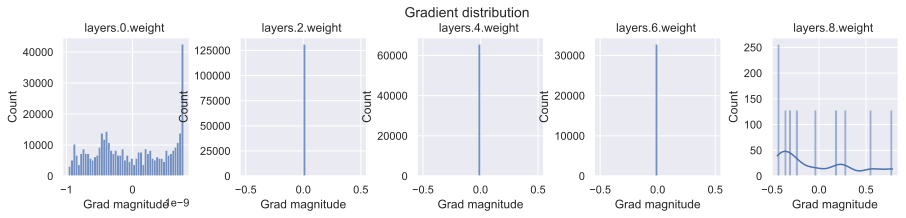

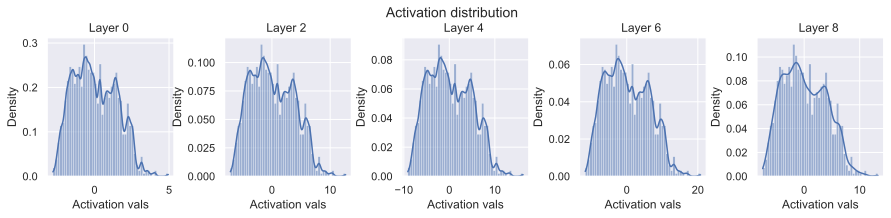

Layer 0 - Variance: 2.0582754611968994
Layer 2 - Variance: 13.489115715026855
Layer 4 - Variance: 22.100555419921875
Layer 6 - Variance: 36.209537506103516
Layer 8 - Variance: 14.831425666809082


In [13]:
def const_init(model, c=0.0):
    for name, param in model.named_parameters():
        param.data.fill_(c)

const_init(model, c=0.005)
visualize_gradients(model)
visualize_activations(model, print_variance=True)

As we can see, only the first and the last layer have diverse gradient distributions while the other three layers have the same gradient for all weights (note that this value is unequal 0, but often very close to it). Having the same gradient for parameters that have been initialized with the same values means that we will always have the same value for those parameters. This would make our layer useless and reduce our effective number of parameters to 1. Thus, we cannot use a constant initialization to train our networks.

## Constant variance
From the experiment above, we have seen that a constant value is not working. So instead, how about we initialize the parameters by randomly sampling from a distribution like a Gaussian? The most intuitive way would be to choose one variance that is used for all layers in the network. Let's implement it below, and visualize the activation distribution across layers.

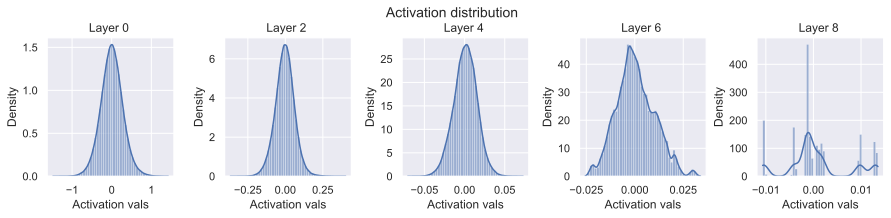

Layer 0 - Variance: 0.07771596312522888
Layer 2 - Variance: 0.00406030984595418
Layer 4 - Variance: 0.00020879440126009285
Layer 6 - Variance: 9.545486682327464e-05
Layer 8 - Variance: 3.965417272411287e-05


In [14]:
def var_init(model, std=0.01):
    for name, param in model.named_parameters():
        param.data.normal_(std=std)

var_init(model, std=0.01)
visualize_activations(model, print_variance=True)

The variance of the activation becomes smaller and smaller across layers, and almost vanishes in the last layer. Alternativaly, we could use a higher standard deviation:

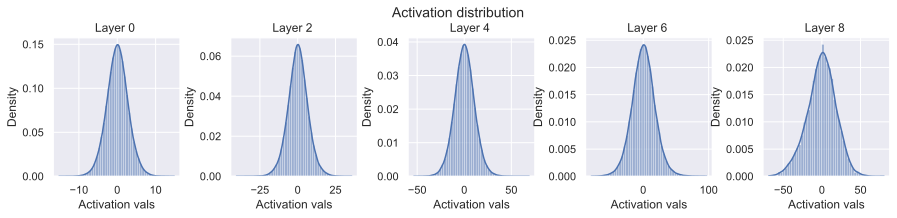

Layer 0 - Variance: 7.925612926483154
Layer 2 - Variance: 43.7206916809082
Layer 4 - Variance: 113.83341979980469
Layer 6 - Variance: 312.201416015625
Layer 8 - Variance: 347.9195861816406


In [15]:
var_init(model, std=0.1)
visualize_activations(model, print_variance=True)

With a higher standard deviation, the activations are likely to explode. You can play around with the specific standard deviation values, but it will be hard to find one that gives us a good activation distribution across layers and is very specific to our model. If we would change the hidden sizes or number of layers, you would have to search all over again, which is neither efficient nor recommended.

## How to find appropriate initialization values

From our experiments above, we have seen that we need to sample the weights from a distribution, but are not sure which one exactly. As a next step, we will try to find the optimal initialization from the perspective of the activation distribution. For this, we state two requirements:

The mean of the activations should be zero
The variance of the activations should stay the same across every layer
Suppose we want to design an initialization for the following layer: 𝑦=𝑊𝑥+𝑏 with 𝑦∈ℝ𝑑𝑦, 𝑥∈ℝ𝑑𝑥. Our goal is that the variance of each element of 𝑦 is the same as the input, i.e. Var(𝑦𝑖)=Var(𝑥𝑖)=𝜎2𝑥, and that the mean is zero. We assume 𝑥 to also have a mean of zero, because, in deep neural networks, 𝑦 would be the input of another layer. This requires the bias and weight to have an expectation of 0. Actually, as 𝑏 is a single element per output neuron and is constant across different inputs, we set it to 0 overall.

Next, we need to calculate the variance with which we need to initialize the weight parameters. Along the calculation, we will need the following variance rule: given two independent variables, the variance of their product is Var(𝑋⋅𝑌)=𝔼(𝑌)2Var(𝑋)+𝔼(𝑋)2Var(𝑌)+Var(𝑋)Var(𝑌)=𝔼(𝑌2)𝔼(𝑋2)−𝔼(𝑌)2𝔼(𝑋)2 (𝑋 and 𝑌 are not refering to 𝑥 and 𝑦, but any random variable).

The needed variance of the weights, Var(𝑤𝑖𝑗), is calculated as follows:

𝑦𝑖Var(𝑦𝑖)=𝜎2𝑥⇒Var(𝑤𝑖𝑗)=𝜎2𝑊=∑𝑗𝑤𝑖𝑗𝑥𝑗Calculation of a single output neuron without bias=Var(∑𝑗𝑤𝑖𝑗𝑥𝑗)=∑𝑗Var(𝑤𝑖𝑗𝑥𝑗)Inputs and weights are independent of each other=∑𝑗Var(𝑤𝑖𝑗)⋅Var(𝑥𝑗)Variance rule (see above) with expectations being zero=𝑑𝑥⋅Var(𝑤𝑖𝑗)⋅Var(𝑥𝑗)Variance equal for all 𝑑𝑥 elements=𝜎2𝑥⋅𝑑𝑥⋅Var(𝑤𝑖𝑗)=1𝑑𝑥

Thus, we should initialize the weight distribution with a variance of the inverse of the input dimension 𝑑𝑥. Let's implement it below and check whether this holds:

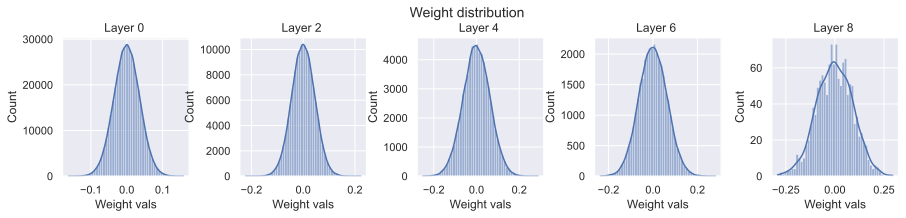

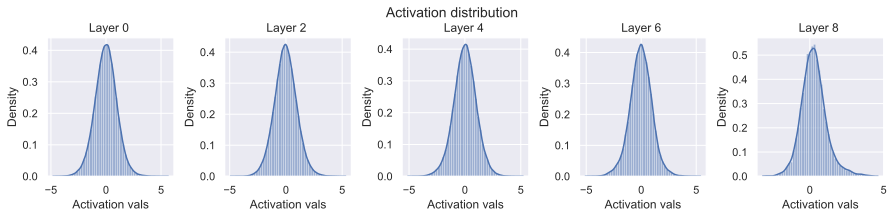

Layer 0 - Variance: 0.9882476925849915
Layer 2 - Variance: 0.9890449643135071
Layer 4 - Variance: 1.0196831226348877
Layer 6 - Variance: 1.0159823894500732
Layer 8 - Variance: 0.7536576986312866


In [17]:
def equal_var_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0) 
        else: 
            param.data.normal_(std=1.0 /math.sqrt(param.shape[1])) 

equal_var_init(model)
visualize_weight_distribution(model)
visualize_activations(model, print_variance=True)

As we expected, the variance stays indeed constant across layers. Note that our initialization does not restrict us to a normal distribution, but allows any other distribution with a mean of 0 and variance of  1/𝑑𝑥 . You often see that a uniform distribution is used for initialization. A small benefit of using a uniform instead of a normal distribution is that we can exclude the chance of initializing very large or small weights.

Besides the variance of the activations, another variance we would like to stabilize is the one of the gradients. This ensures a stable optimization for deep networks. It turns out that we can do the same calculation as above starting from  Δ𝑥=𝑊Δ𝑦 , and come to the conclusion that we should initialize our layers with  1/𝑑𝑦  where  𝑑𝑦  is the number of output neurons. You can do the calculation as a practice, or check a thorough explanation in this blog post. As a compromise between both constraints, Glorot and Bengio (2010) proposed to use the harmonic mean of both values. This leads us to the well-known Xavier initialization:

𝑊∼(0,2𝑑𝑥+𝑑𝑦) 

If we use a uniform distribution, we would initialize the weights with:

𝑊∼𝑈[−6‾√𝑑𝑥+𝑑𝑦‾‾‾‾‾‾‾√,6‾√𝑑𝑥+𝑑𝑦‾‾‾‾‾‾‾√] 


Let's shortly implement it and validate its effectiveness:

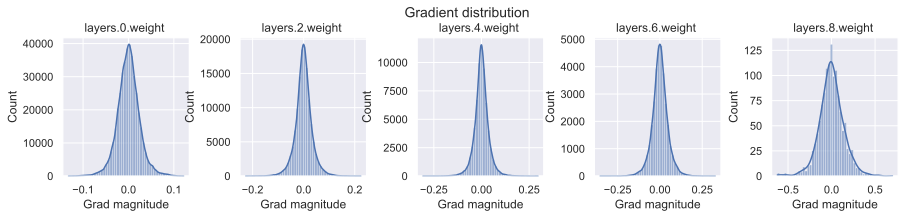

layers.0.weight - Variance: 0.0005975761450827122
layers.2.weight - Variance: 0.00107382086571306
layers.4.weight - Variance: 0.0013981543015688658
layers.6.weight - Variance: 0.00215104385279119
layers.8.weight - Variance: 0.020080892369151115


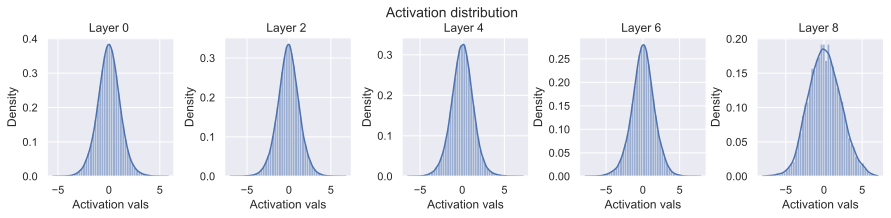

Layer 0 - Variance: 1.2443994283676147
Layer 2 - Variance: 1.6894475221633911
Layer 4 - Variance: 1.7133890390396118
Layer 6 - Variance: 2.432518482208252
Layer 8 - Variance: 4.493688106536865


In [19]:
def xavier_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0) 
        else: 
            bound= math.sqrt(6) / math.sqrt(param.shape[0]+param.shape[1])
            param.data.uniform_(-bound,bound) 

xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

We see that the Xavier initialization balances the variance of gradients and activations. Note that the significantly higher variance for the output layer is due to the large difference of input and output dimension ( 128  vs  10 ). However, we currently assumed the activation function to be linear. So what happens if we add a non-linearity? In a tanh-based network, a common assumption is that for small values during the initial steps in training, the  tanh  works as a linear function such that we don't have to adjust our calculation. We can check if that is the case for us as well:

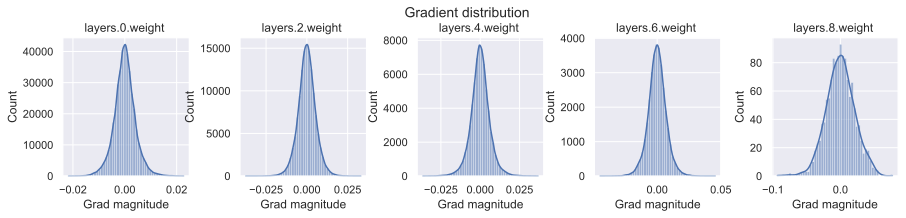

layers.0.weight - Variance: 1.6712088836356997e-05
layers.2.weight - Variance: 2.9089935196680017e-05
layers.4.weight - Variance: 3.600309355533682e-05
layers.6.weight - Variance: 4.958264617016539e-05
layers.8.weight - Variance: 0.0004495441971812397


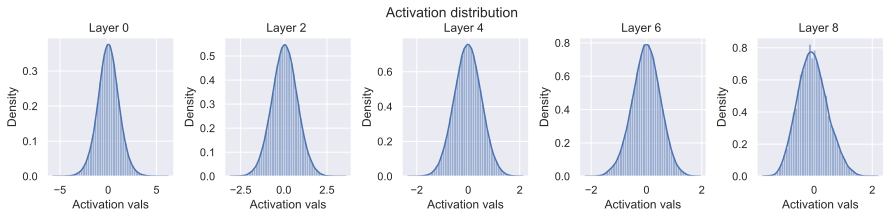

Layer 0 - Variance: 1.2616938352584839
Layer 2 - Variance: 0.544843316078186
Layer 4 - Variance: 0.27532386779785156
Layer 6 - Variance: 0.26287856698036194
Layer 8 - Variance: 0.26193127036094666


In [20]:
model = BaseNetwork(act_fn=nn.Tanh()).to(device)
xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

Although the variance decreases over depth, it is apparent that the activation distribution becomes more focused on the low values. Therefore, our variance will stabilize around 0.25 if we would go even deeper. Hence, we can conclude that the Xavier initialization works well for Tanh networks. But what about ReLU networks? Here, we cannot take the previous assumption of the non-linearity becoming linear for small values. The ReLU activation function sets (in expectation) half of the inputs to 0 so that also the expectation of the input is not zero. However, as long as the expectation of  𝑊  is zero and  𝑏=0 , the expectation of the output is zero. The part where the calculation of the ReLU initialization differs from the identity is when determining  Var(𝑤𝑖𝑗𝑥𝑗) :

Var(𝑤𝑖𝑗𝑥𝑗)=𝔼[𝑤2𝑖𝑗]⏟=Var(𝑤𝑖𝑗)𝔼[𝑥2𝑗]−𝔼[𝑤𝑖𝑗]2⏟=0𝔼[𝑥𝑗]2=Var(𝑤𝑖𝑗)𝔼[𝑥2𝑗] 

If we assume now that  𝑥  is the output of a ReLU activation (from a previous layer,  𝑥=𝑚𝑎𝑥(0,𝑦̃ ) ), we can calculate the expectation as follows:

𝔼[𝑥2]=𝔼[max(0,𝑦̃ )2]=12𝔼[𝑦̃ 2]𝑦̃  is zero-centered and symmetric=12Var(𝑦̃ ) 

Thus, we see that we have an additional factor of 1/2 in the equation, so that our desired weight variance becomes  2/𝑑𝑥 . This gives us the Kaiming initialization (see He, K. et al. (2015)). Note that the Kaiming initialization does not use the harmonic mean between input and output size. In their paper (Section 2.2, Backward Propagation, last paragraph), they argue that using  𝑑𝑥  or  𝑑𝑦  both lead to stable gradients throughout the network, and only depend on the overall input and output size of the network. Hence, we can use here only the input  𝑑𝑥 :

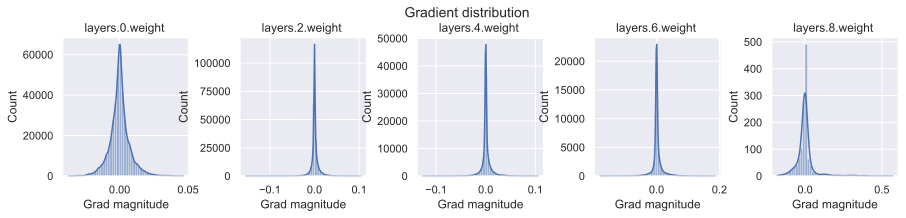

layers.0.weight - Variance: 5.593949754256755e-05
layers.2.weight - Variance: 8.165083272615448e-05
layers.4.weight - Variance: 9.535307617625222e-05
layers.6.weight - Variance: 0.0002848390431609005
layers.8.weight - Variance: 0.003961426205933094


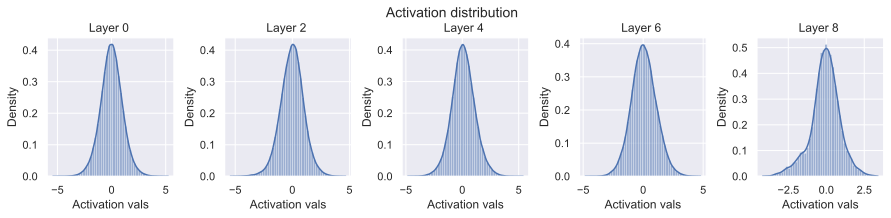

Layer 0 - Variance: 1.0332646369934082
Layer 2 - Variance: 1.0350598096847534
Layer 4 - Variance: 1.0465646982192993
Layer 6 - Variance: 1.082282304763794
Layer 8 - Variance: 0.9255362749099731


In [21]:
def kaiming_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        elif name.startswith("layers.0"): # The first layer does not have ReLU applied on its input
            param.data.normal_(0, 1/math.sqrt(param.shape[1]))
        else:
            param.data.normal_(0, math.sqrt(2)/math.sqrt(param.shape[1]))

model = BaseNetwork(act_fn=nn.ReLU()).to(device)
kaiming_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

The variance stays stable across layers. We can conclude that the Kaiming initialization indeed works well for ReLU-based networks. Note that for Leaky-ReLU etc., we have to slightly adjust the factor of  2  in the variance as half of the values are not set to zero anymore. PyTorch provides a function to calculate this factor for many activation function, see torch.nn.init.calculate_gain (link).

# Optimization

Besides initialization, selecting a suitable optimization algorithm can be an important choice for deep neural networks. Before taking a closer look at them, we should define code for training the models. Most of the following code is copied from the previous notebook, and only slightly altered to fit our needs.

In [23]:
def _get_config_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".tar")

def _get_result_file(model_path, model_name):
    return os.path.join(model_path, model_name + "_results.json")

def load_model(model_path, model_name, net=None):
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), f"Could not find the config file \"{config_file}\". Are you sure this is the correct path and you have your model config stored here?"
    assert os.path.isfile(model_file), f"Could not find the model file \"{model_file}\". Are you sure this is the correct path and you have your model stored here?"
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        assert act_fn_name in act_fn_by_name, f"Unknown activation function \"{act_fn_name}\". Please add it to the \"act_fn_by_name\" dict."
        act_fn = act_fn_by_name[act_fn_name]()
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file))
    return net

def save_model(model, model_path, model_name):
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

def train_model(net, model_name, optim_func, max_epochs=50, batch_size=256, overwrite=False):
    """
    Train a model on the training set of FashionMNIST

    Inputs:
        net - Object of BaseNetwork
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_epochs - Number of epochs we want to (maximally) train for
        patience - If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size - Size of batches used in training
        overwrite - Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print(f"Model file of \"{model_name}\" already exists. Skipping training...")
        with open(_get_result_file(CHECKPOINT_PATH, model_name), "r") as f:
            results = json.load(f)
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")

        # Defining optimizer, loss and data loader
        optimizer =  optim_func(net.parameters())
        loss_module = nn.CrossEntropyLoss()
        train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        results = None
        val_scores = []
        train_losses, train_scores = [], []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ############
            # Training #
            ############
            net.train()
            true_preds, count = 0., 0
            t = tqdm(train_loader_local, leave=False)
            for imgs, labels in t:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()
                # Record statistics during training
                true_preds += (preds.argmax(dim=-1) == labels).sum().item()
                count += labels.shape[0]
                t.set_description(f"Epoch {epoch+1}: loss={loss.item():4.2f}")
                train_losses.append(loss.item())
            train_acc = true_preds / count
            train_scores.append(train_acc)

            ##############
            # Validation #
            ##############
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch

    if results is None:
        load_model(CHECKPOINT_PATH, model_name, net=net)
        test_acc = test_model(net, test_loader)
        results = {"test_acc": test_acc, "val_scores": val_scores, "train_losses": train_losses, "train_scores": train_scores}
        with open(_get_result_file(CHECKPOINT_PATH, model_name), "w") as f:
            json.dump(results, f)

    # Plot a curve of the validation accuracy
    sns.set()
    plt.plot([i for i in range(1,len(results["train_scores"])+1)], results["train_scores"], label="Train")
    plt.plot([i for i in range(1,len(results["val_scores"])+1)], results["val_scores"], label="Val")
    plt.xlabel("Epochs")
    plt.ylabel("Validation accuracy")
    plt.ylim(min(results["val_scores"]), max(results["train_scores"])*1.01)
    plt.title(f"Validation performance of {model_name}")
    plt.legend()
    plt.show()
    plt.close()

    print((f" Test accuracy: {results['test_acc']*100.0:4.2f}% ").center(50, "=")+"\n")
    return results


def test_model(net, data_loader):
    """
    Test a model on a specified dataset.

    Inputs:
        net - Trained model of type BaseNetwork
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc

First, we need to understand what an optimizer actually does. The optimizer is responsible to update the network's parameters given the gradients. Hence, we effectively implement a function  𝑤𝑡=𝑓(𝑤𝑡−1,𝑔𝑡,...)  with  𝑤  being the parameters, and  𝑔𝑡=∇𝑤(𝑡−1)(𝑡)  the gradients at time step  𝑡 . A common, additional parameter to this function is the learning rate, here denoted by  𝜂 . Usually, the learning rate can be seen as the "step size" of the update. A higher learning rate means that we change the weights more in the direction of the gradients, a smaller means we take shorter steps.

As most optimizers only differ in the implementation of  𝑓 , we can define a template for an optimizer in PyTorch below. We take as input the parameters of a model and a learning rate. The function zero_grad sets the gradients of all parameters to zero, which we have to do before calling loss.backward(). Finally, the step() function tells the optimizer to update all weights based on their gradients. The template is setup below:

In [24]:
class OptimizerTemplate:

    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr

    def zero_grad(self):
        ## Set gradients of all parameters to zero
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_() # For second-order optimizers important
                p.grad.zero_()

    @torch.no_grad()
    def step(self):
        ## Apply update step to all parameters
        for p in self.params:
            if p.grad is None: # We skip parameters without any gradients
                continue
            self.update_param(p)

    def update_param(self, p):
        # To be implemented in optimizer-specific classes
        raise NotImplementedError

The first optimizer we are going to implement is the standard Stochastic Gradient Descent (SGD). SGD updates the parameters using the following equation:

𝑤(𝑡)=𝑤(𝑡−1)−𝜂⋅𝑔(𝑡) 

As simple as the equation is also our implementation of SGD:

In [25]:
class SGD(OptimizerTemplate):

    def __init__(self, params, lr):
        super().__init__(params, lr)

    def update_param(self, p):
        p_update = -self.lr * p.grad
        p.add_(p_update) # In-place update => saves memory and does not create computation graph

Remember the concept of momentum which replaces the gradient in the update by an exponential average of all past gradients including the current one:

𝑚(𝑡)𝑤(𝑡)=𝛽1𝑚(𝑡−1)+(1−𝛽1)⋅𝑔(𝑡)=𝑤(𝑡−1)−𝜂⋅𝑚(𝑡) 

Let's also implement it below:

In [26]:
class SGDMomentum(OptimizerTemplate):

    def __init__(self, params, lr, momentum=0.0):
        super().__init__(params, lr)
        self.momentum = momentum # Corresponds to beta_1 in the equation above
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params} # Dict to store m_t

    def update_param(self, p):
        self.param_momentum[p] = (1 - self.momentum) * p.grad + self.momentum * self.param_momentum[p]
        p_update = -self.lr * self.param_momentum[p]
        p.add_(p_update)

Finally, we arrive at Adam. Adam combines the idea of momentum with an adaptive learning rate, which is based on an exponential average of the squared gradients, i.e. the gradients norm. Furthermore, we add a bias correction for the momentum and adaptive learning rate for the first iterations:

𝑚(𝑡)𝑣(𝑡)𝑚̂ (𝑡)𝑤(𝑡)=𝛽1𝑚(𝑡−1)+(1−𝛽1)⋅𝑔(𝑡)=𝛽2𝑣(𝑡−1)+(1−𝛽2)⋅(𝑔(𝑡))2=𝑚(𝑡)1−𝛽𝑡1,𝑣̂ (𝑡)=𝑣(𝑡)1−𝛽𝑡2=𝑤(𝑡−1)−𝜂𝑣̂ (𝑡)‾‾‾√+𝜖∘𝑚̂ (𝑡) 

Epsilon is a small constant used to improve numerical stability for very small gradient norms. Remember that the adaptive learning rate does not replace the learning rate hyperparameter  𝜂 , but rather acts as an extra factor and ensures that the gradients of various parameters have a similar norm.

In [27]:
class Adam(OptimizerTemplate):

    def __init__(self, params, lr, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.param_step = {p: 0 for p in self.params} # Remembers "t" for each parameter for bias correction
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params}
        self.param_2nd_momentum = {p: torch.zeros_like(p.data) for p in self.params}

    def update_param(self, p):
        self.param_step[p] += 1

        self.param_momentum[p] = (1 - self.beta1) * p.grad + self.beta1 * self.param_momentum[p]
        self.param_2nd_momentum[p] = (1 - self.beta2) * (p.grad)**2 + self.beta2 * self.param_2nd_momentum[p]

        bias_correction_1 = 1 - self.beta1 ** self.param_step[p]
        bias_correction_2 = 1 - self.beta2 ** self.param_step[p]

        p_2nd_mom = self.param_2nd_momentum[p] / bias_correction_2
        p_mom = self.param_momentum[p] / bias_correction_1
        p_lr = self.lr / (torch.sqrt(p_2nd_mom) + self.eps)
        p_update = -p_lr * p_mom

        p.add_(p_update)

## Comparing optimizers on model training

After we have implemented three optimizers (SGD, SGD with momentum, and Adam), we can start to analyze and compare them. First, we test them on how well they can optimize a neural network on the FashionMNIST dataset. We use again our linear network, this time with a ReLU activation and the kaiming initialization, which we have found before to work well for ReLU-based networks. Note that the model is over-parameterized for this task, and we can achieve similar performance with a much smaller network (for example 100,100,100). However, our main interest is in how well the optimizer can train deep neural networks, hence the over-parameterization.

In [29]:
base_model = BaseNetwork(act_fn=nn.ReLU(), hidden_sizes=[512,256,256,128])
kaiming_init(base_model)

For a fair comparison, we train the exact same model with the same seed with the three optimizers below. Feel free to change the hyperparameters if you want (however, you have to train your own model then).

Model file of "FashionMNIST_SGD" already exists. Skipping training...


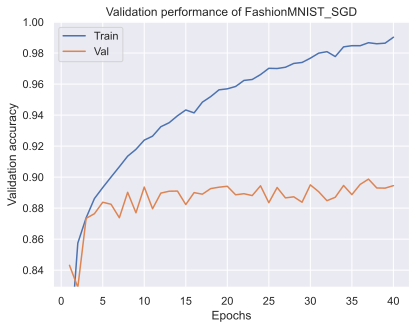

============= Test accuracy: 89.09% ==============



In [30]:
SGD_model = copy.deepcopy(base_model).to(device)
SGD_results = train_model(SGD_model, "FashionMNIST_SGD",
                          lambda params: SGD(params, lr=1e-1),
                          max_epochs=40, batch_size=256)